<a href="https://colab.research.google.com/github/CleanOOP/StudyAI/blob/Week1Homework/1_1_Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression 실습

이번 실습에서는 linear regression에 대한 gradient descent를 직접 구현해봅니다. 여기서 사용할 문제들은 크게 두 가지로 OR 문제와 XOR 문제입니다.

먼저 필요한 library들을 import합시다.

In [1]:
import torch
import numpy as np

## OR Problem

OR은 0 또는 1의 값을 가질 수 있는 두 개의 정수를 입력으로 받아 둘 중에 하나라도 1이면 1을 출력하고 아니면 0을 출력하는 문제입니다.
즉, 우리가 학습하고자 하는 함수는 2개의 정수를 입력받아 하나의 정수를 출력하면됩니다. 이러한 함수를 학습하기 위한 data는 다음과 같이 구성할 수 있습니다.

In [2]:
x = torch.tensor([
    [0., 0.],
    [0., 1.],
    [1., 0.],
    [1., 1.]
])
y = torch.tensor([0, 1, 1, 1])

print(x.shape, y.shape)

torch.Size([4, 2]) torch.Size([4])


출력 결과에서 볼 수 있다시피 $x$의 shape은 (4, 2)로, 총 4개의 two-dimensional data 임을 알 수 있습니다. $y$는 각 $x_i$에 대한 label로 우리가 설정한 문제의 조건을 잘 따라가는 것을 알 수 있습니다.

다음으로는 linear regression의 parameter들인 $w, b$를 정의하겠습니다.

In [5]:
w = torch.randn((1, 2))
b = torch.randn((1, 1))

print(w.shape, b.shape)

torch.Size([1, 2]) torch.Size([1, 1])


$w$는 1x2의 벡터이고 $b$는 1x1의 scalar임을 알 수 있습니다. 여기서는 `torch.randn`을 사용하여 standard normal distribution을 가지고 초기화하였습니다.

이러한 $w, b$와 data $x, y$가 주어졌을 때 우리가 학습한 $w, b$의 성능을 평가하는 함수를 구현합시다.
평가 함수는 다음과 같이 MSE로 정의됩니다:
$$l(f) := MSE(f(x), y) = \frac{1}{n} \sum_{i=1}^n (f(x_i) - y)^2.$$
이를 구현한 코드는 다음과 같습니다.

In [6]:
def pred(w, b, x):
  return torch.matmul(w, x.T) + b


def loss(w, b, x, y):
  return (y - pred(w, b, x)).pow(2).mean()

먼저 `def pred(w, b, x)`는 $wx^T + b$, 즉 1차 함수 $f$의 $x$에 대한 결과를 반환하는 함수를 구현했습니다.
이를 이용하여 주어진 label $y$와의 MSE를 측정하는 코드가 `def loss(w, b, x, y)`에 구현되어있습니다.

다음은 MSE를 기반으로 $w, b$의 gradient를 구하는 코드를 구현하겠습니다.
MSE에 대한 $w$의 gradient는 다음과 같이 구할 수 있습니다:
$$\frac{\partial l}{\partial w} = \frac{1}{n} \sum_{i=1}^n 2(wx_i^T + b - y)x_i.$$
$b$에 대한 gradient는 다음과 같습니다:
$$\frac{\partial l}{\partial b} = \frac{1}{n} \sum_{i=1}^n 2(wx_i^T + b - y).$$
이를 코드로 구현하면 다음과 같습니다.

In [7]:
def grad_w(w, b, x, y):
  # w: (1, d), b: (1, 1), x: (n, d), y: (n)
  tmp1 = torch.matmul(w, x.T)  # (1, n)
  tmp2 = tmp1 + b              # (1, n)
  tmp3 = 2 * (tmp2 - y[None])  # (1, n)
  grad_item = tmp3.T * x       # (n, d)
  return grad_item.mean(dim=0, keepdim=True)  # (1, d)


def grad_b(w, b, x, y):
  # w: (1, d), b: (1, 1), x: (n, d), y: (n)
  grad_item = 2 * (torch.matmul(w, x.T) + b - y[None])  # (1, n)
  return grad_item.mean(dim=-1, keepdim=True)           # (1, 1)

여기서 중요한 것은 shape에 맞춰서 연산을 잘 사용해야한다는 것입니다. Shape과 관련된 설명은 `[Chapter 0]`의 Numpy에서 설명했으니, 복습하신다는 느낌으로 주석으로 써놓은 shape들을 유도해보시면 좋을 것 같습니다. 중요한 것은 반환되는 tensor의 shape이 우리가 구하고자 하는 gradient와 일치해야 한다는 것입니다. 예를 들어 $w$의 $l$에 대한 gradient는 $w$와 shape이 동일해야 합니다.

마지막으로 gradient descent 함수를 구현하겠습니다. Gradient descent는 다음과 같이 정의됩니다:
$$w^{(new)} = w^{(old)} - \eta \frac{\partial l}{\partial w} \biggr\rvert_{w = w^{(old)}}.$$
Gradient는 위에서 구현했으니 이를 활용하여 learning rate $\eta$가 주어졌을 때 $w, b$를 update하는 코드를 구현할 수 있습니다. 구현한 결과는 다음과 같습니다.

In [8]:
def update(x, y, w, b, lr):
  w = w - lr * grad_w(w, b, x, y)
  b = b - lr * grad_b(w, b, x, y)
  return w, b

Gradient descent에 해당하는 코드는 모두 구현하였습니다. 이제 학습하는 코드를 구현하겠습니다:

In [9]:
def train(n_epochs, lr, w, b, x, y):
  for e in range(n_epochs):
    w, b = update(x, y, w, b, lr)
    print(f"Epoch {e:3d} | Loss: {loss(w, b, x, y)}")
  return w, b

여기서 `n_epochs`는 update를 하는 횟수를 의미합니다. 매 update 이후에 `loss` 함수를 사용하여 잘 수렴하고 있는지 살펴봅니다. 실제로 이 함수를 실행한 결과는 다음과 같습니다.

In [10]:
n_epochs = 100
lr = 0.1

w, b = train(n_epochs, lr, w, b, x, y)
print(w, b)

Epoch   0 | Loss: 0.19179020822048187
Epoch   1 | Loss: 0.17894583940505981
Epoch   2 | Loss: 0.16748864948749542
Epoch   3 | Loss: 0.15721547603607178
Epoch   4 | Loss: 0.14797675609588623
Epoch   5 | Loss: 0.13965463638305664
Epoch   6 | Loss: 0.13215114176273346
Epoch   7 | Loss: 0.125382199883461
Epoch   8 | Loss: 0.11927397549152374
Epoch   9 | Loss: 0.11376101523637772
Epoch  10 | Loss: 0.1087847501039505
Epoch  11 | Loss: 0.10429259389638901
Epoch  12 | Loss: 0.10023726522922516
Epoch  13 | Loss: 0.09657621383666992
Epoch  14 | Loss: 0.0932709351181984
Epoch  15 | Loss: 0.09028685837984085
Epoch  16 | Loss: 0.08759266883134842
Epoch  17 | Loss: 0.08516019582748413
Epoch  18 | Loss: 0.08296399563550949
Epoch  19 | Loss: 0.08098104596138
Epoch  20 | Loss: 0.07919059693813324
Epoch  21 | Loss: 0.07757396996021271
Epoch  22 | Loss: 0.07611428201198578
Epoch  23 | Loss: 0.07479622960090637
Epoch  24 | Loss: 0.07360605895519257
Epoch  25 | Loss: 0.07253137230873108
Epoch  26 | Loss: 0

잘 수렴하는 것을 확인하였습니다. 마지막으로 OR data에 대한 $w, b$의 예측 결과와 label을 비교해봅시다.

In [11]:
print(pred(w, b, x))
print(y)

tensor([[0.2480, 0.7529, 0.7466, 1.2514]])
tensor([0, 1, 1, 1])


예측 결과를 볼 수 있다시피 우리의 linear regression model은 0과 1에 해당하는 data를 잘 구분하는 것을 알 수 있습니다.

# XOR Problem

이번에는 XOR를 학습해보겠습니다. XOR은 OR과 똑같은 입력을 받는 문제로, 두 개의 0 또는 1의 정수가 들어왔을 때 두 정수가 다르면 1, 아니면 0을 출력해야 합니다.
먼저 data를 만들어보겠습니다:

In [12]:
x = torch.tensor([
    [0., 0.],
    [0., 1.],
    [1., 0.],
    [1., 1.]
])
y = torch.tensor([0, 1, 1, 0])

print(x.shape, y.shape)

torch.Size([4, 2]) torch.Size([4])


보시다시피 shape이나 생성 과정은 OR과 똑같습니다. 다른 것은 $y$에서의 labeling입니다. OR과 다르게 $x = (1, 1)$에 대해서는 0을 labeling했습니다.
이러한 사소한 차이에 대해서도 linear regression model이 잘 학습할 수 있을지 살펴보겠습니다.

In [13]:
n_epochs = 100
lr = 0.1

w, b = train(n_epochs, lr, w, b, x, y)
print(w, b)

Epoch   0 | Loss: 0.3775087893009186
Epoch   1 | Loss: 0.3447214365005493
Epoch   2 | Loss: 0.32608547806739807
Epoch   3 | Loss: 0.3147139549255371
Epoch   4 | Loss: 0.30714818835258484
Epoch   5 | Loss: 0.3016403913497925
Epoch   6 | Loss: 0.29729896783828735
Epoch   7 | Loss: 0.2936630845069885
Epoch   8 | Loss: 0.2904892563819885
Epoch   9 | Loss: 0.2876449227333069
Epoch  10 | Loss: 0.2850548028945923
Epoch  11 | Loss: 0.2826734185218811
Epoch  12 | Loss: 0.2804712653160095
Epoch  13 | Loss: 0.2784278690814972
Epoch  14 | Loss: 0.27652767300605774
Epoch  15 | Loss: 0.27475830912590027
Epoch  16 | Loss: 0.27310943603515625
Epoch  17 | Loss: 0.2715718448162079
Epoch  18 | Loss: 0.27013757824897766
Epoch  19 | Loss: 0.2687993347644806
Epoch  20 | Loss: 0.26755040884017944
Epoch  21 | Loss: 0.2663847804069519
Epoch  22 | Loss: 0.2652967870235443
Epoch  23 | Loss: 0.26428115367889404
Epoch  24 | Loss: 0.2633330225944519
Epoch  25 | Loss: 0.26244792342185974
Epoch  26 | Loss: 0.26162159

이전과는 다르게 loss가 1.0보다 작아지지 않는 것을 알 수 있습니다. 실제 예측 결과를 살펴보면 다음과 같습니다.

In [14]:
print(pred(w, b, x))
print(y)

tensor([[0.4859, 0.4981, 0.4980, 0.5101]])
tensor([0, 1, 1, 0])


보시다시피 0과 1에 해당하는 data들을 잘 구분하지 못하는 모습니다. Linear regression model은 XOR을 잘 처리하지 못하는 것을 우리는 이번 실습을 통해 알 수 있습니다.

Epoch 1, Train Accuracy: 33.98%, Test Accuracy: 43.59%
Finished Training
Epoch 2, Train Accuracy: 45.72%, Test Accuracy: 48.32%
Finished Training
Epoch 3, Train Accuracy: 49.94%, Test Accuracy: 52.37%
Finished Training
Epoch 4, Train Accuracy: 53.07%, Test Accuracy: 55.38%
Finished Training
Epoch 5, Train Accuracy: 55.77%, Test Accuracy: 57.88%
Finished Training
Epoch 6, Train Accuracy: 57.44%, Test Accuracy: 58.42%
Finished Training
Epoch 7, Train Accuracy: 59.17%, Test Accuracy: 60.91%
Finished Training
Epoch 8, Train Accuracy: 60.78%, Test Accuracy: 62.32%
Finished Training
Epoch 9, Train Accuracy: 61.95%, Test Accuracy: 62.40%
Finished Training
Epoch 10, Train Accuracy: 63.01%, Test Accuracy: 64.44%
Finished Training
Epoch 11, Train Accuracy: 64.10%, Test Accuracy: 64.88%
Finished Training
Epoch 12, Train Accuracy: 65.16%, Test Accuracy: 66.52%
Finished Training
Epoch 13, Train Accuracy: 66.26%, Test Accuracy: 68.05%
Finished Training
Epoch 14, Train Accuracy: 67.19%, Test Accuracy

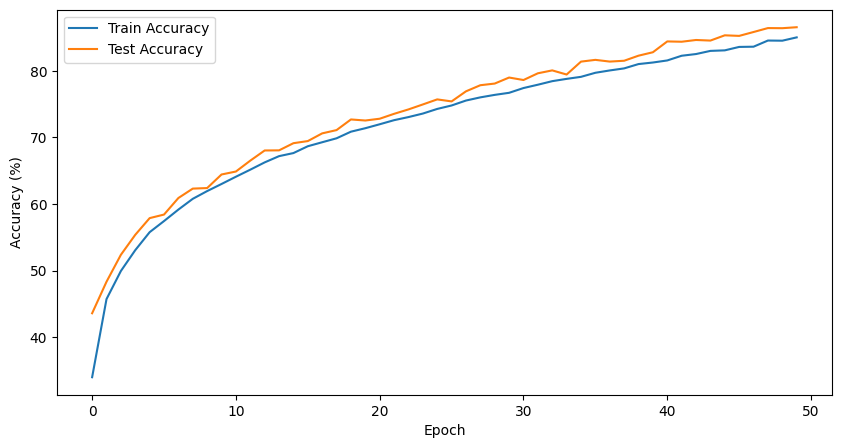

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

# 클래스 이름 정의
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 신경망 모델 정의
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
    self.leaky_relu = nn.LeakyReLU(0.01)
  def forward(self,x):
    x = self.pool(self.leaky_relu(self.conv1(x)))
    x = self.pool(self.leaky_relu(self.conv2(x)))
    x = torch.flatten(x,1) #모든 차원을 평탄화
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

# 손실함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# 학습루프
n_epochs = 50
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    net.train()
    for i, data in enumerate(trainloader,0):
      inputs, labels = data

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    #테스트 루프
    correct_test = 0
    total_test = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
          images, labels= data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
    print('Finished Training')

# plot 1: SGD vs Adam
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Leaky ReLU vs Sigmoid
class SigmoidNet(nn.Module):
  def __init__(self):
    super(SigmoidNet, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.pool(self.sigmoid(self.conv1(x)))
    x = self.pool(self.sigmoid(self.conv2(x)))
    x = torch.flatten(x, 1) # 모든 차원 평탄화
    x = self.sigmoid(self.fc1(x))
    x = self.sigmoid(self.fc2(x))
    x = self.fc3(x)
    return x

sigmoid_net = SigmoidNet()
sigmoid_optimizer = optim.Adam(sigmoid_net.parameters(), lr=0.001, weight_decay=1e-4)

sigmoid_train_accuracies = []
sigmoid_test_accuracies = []

for epoch in range(n_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    sigmoid_net.train()
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data

      sigmoid_optimizer.zero_grad()

      outputs = sigmoid_net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      sigmoid_optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()

    sigmoid_train_accuracy = 100 * correct_train / total_train
    sigmoid_train_accuracies.append(sigmoid_train_accuracy)

    # 테스트 루프
    correct_test = 0
    total_test = 0
    sigmoid_net.eval()
    with torch.no_grad():
       for data in testloader :
         images

















